# 0. Unzip `Directions01.zip` file

In [3]:
!unzip Directions01.zip

Archive:  Directions01.zip
  inflating: Directions01/list_test.txt  
  inflating: Directions01/list_train.txt  
  inflating: Directions01/test/down/1.png  
  inflating: Directions01/test/down/10.png  
  inflating: Directions01/test/down/2.png  
  inflating: Directions01/test/down/3.png  
  inflating: Directions01/test/down/4.png  
  inflating: Directions01/test/down/5.png  
  inflating: Directions01/test/down/6.png  
  inflating: Directions01/test/down/7.png  
  inflating: Directions01/test/down/8.png  
  inflating: Directions01/test/down/9.png  
  inflating: Directions01/test/left/1.png  
  inflating: Directions01/test/left/10.png  
  inflating: Directions01/test/left/2.png  
  inflating: Directions01/test/left/3.png  
  inflating: Directions01/test/left/4.png  
  inflating: Directions01/test/left/5.png  
  inflating: Directions01/test/left/6.png  
  inflating: Directions01/test/left/7.png  
  inflating: Directions01/test/left/8.png  
  inflating: Directions01/test/left/9.png  
  infl

# 1. Creating `datasets` and `dataloaders`

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
train_dir = "Directions01/train"
test_dir = "Directions01/test"

train_dir, test_dir

('Directions01/train', 'Directions01/test')

In [8]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 948
     Root location: Directions01/train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 40
     Root location: Directions01/test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [9]:
class_names = train_data.classes
class_names

['down', 'left', 'right', 'up']

In [10]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'down': 0, 'left': 1, 'right': 2, 'up': 3}

Image shape: torch.Size([3, 128, 128])


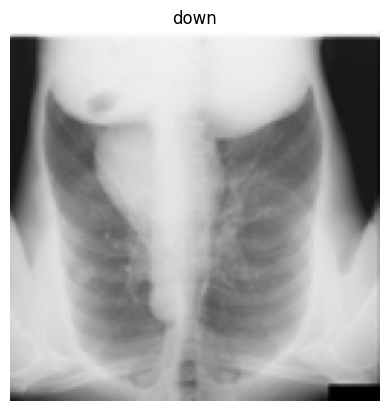

In [11]:
import numpy as np
import matplotlib.pyplot as plt

sample_img = train_data[0][0]
sample_img_transformed = np.array(sample_img.permute(1, 2, 0))
plt.imshow(sample_img_transformed)
plt.title(class_names[0])
plt.axis(False);
print(f"Image shape: {sample_img.shape}")

In [12]:
import os
os.cpu_count()

2

In [13]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers = os.cpu_count())

In [14]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7995d9dd3250>,
 <torch.utils.data.dataloader.DataLoader at 0x7995d9dd1e40>)

In [15]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [16]:
for img, label in train_dataloader:
  print(img.shape, label.shape)
  break

torch.Size([32, 3, 128, 128]) torch.Size([32])


# 2. Creating a pretrained model

In [17]:
from torchvision.models import resnet18
from torch import nn

In [18]:
len(class_names)

4

In [19]:
resnet18 = resnet18(pretrained=True)
num_classes = len(class_names)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.8MB/s]


# 3. Setting up optimizer and loss function

In [20]:
from torch import optim

lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet18.parameters(),
                       lr=lr)

In [21]:
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [22]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# 4. Training and Testing loops

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()



  for batch, (X, y) in enumerate(data_loader):
    optimizer.zero_grad()
    X, y = X.to(device), y.to(device)

    y_preds = model(X)

    loss = loss_fn(y_preds, y)
    train_loss+=loss.item()
    train_acc += accuracy_fn(y, y_preds.argmax(dim=1))

    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}")

In [24]:

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      y_preds = model(X)

      loss = loss_fn(y_preds, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y, y_preds.argmax(dim=1))


  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}")

In [25]:
from tqdm.auto import tqdm

epochs = 10
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----------------")

  train_step(model=resnet18,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=resnet18,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-----------------
Train Loss: 0.0588 | Train Accuracy: 97.29
Test Loss: 0.0039 | Test Accuracy: 100.00
Epoch: 1
-----------------
Train Loss: 0.0004 | Train Accuracy: 100.00
Test Loss: 0.0000 | Test Accuracy: 100.00
Epoch: 2
-----------------
Train Loss: 0.0004 | Train Accuracy: 100.00
Test Loss: 0.0001 | Test Accuracy: 100.00
Epoch: 3
-----------------
Train Loss: 0.0412 | Train Accuracy: 98.75
Test Loss: 0.6244 | Test Accuracy: 84.38
Epoch: 4
-----------------
Train Loss: 0.0157 | Train Accuracy: 99.42
Test Loss: 0.0441 | Test Accuracy: 100.00
Epoch: 5
-----------------
Train Loss: 0.0148 | Train Accuracy: 99.58
Test Loss: 0.0008 | Test Accuracy: 100.00
Epoch: 6
-----------------
Train Loss: 0.0022 | Train Accuracy: 99.83
Test Loss: 0.0057 | Test Accuracy: 100.00
Epoch: 7
-----------------
Train Loss: 0.0075 | Train Accuracy: 99.90
Test Loss: 0.0001 | Test Accuracy: 100.00
Epoch: 8
-----------------
Train Loss: 0.0050 | Train Accuracy: 99.79
Test Loss: 0.0000 | Test Accuracy

# 5. Visualizing Predictions

In [63]:
def make_predictions(model:torch.nn.Module,
                     data: list,
                     device:device):
  pred_probs = []

  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [64]:
import random

random_samples = []
random_labels = []

for sample, label in random.sample(list(test_data), k=9):
  random_samples.append(sample)
  random_labels.append(label)

len(random_samples), len(random_labels)

(9, 9)

In [65]:
pred_probs = make_predictions(model=resnet18,
                              data=random_samples,
                              device=device)

# Viewing first two prediction probabilities list
pred_probs[:2]

tensor([[9.9997e-01, 1.3978e-05, 2.0652e-06, 1.0504e-05],
        [9.9997e-01, 1.3606e-05, 2.4120e-06, 1.3281e-05]])

In [68]:
pred_classes = torch.argmax(pred_probs, dim=1)
pred_classes

tensor([0, 0, 2, 1, 0, 2, 0, 1, 2])

In [71]:
random_labels, pred_classes

([0, 0, 2, 1, 0, 2, 0, 1, 2], tensor([0, 0, 2, 1, 0, 2, 0, 1, 2]))

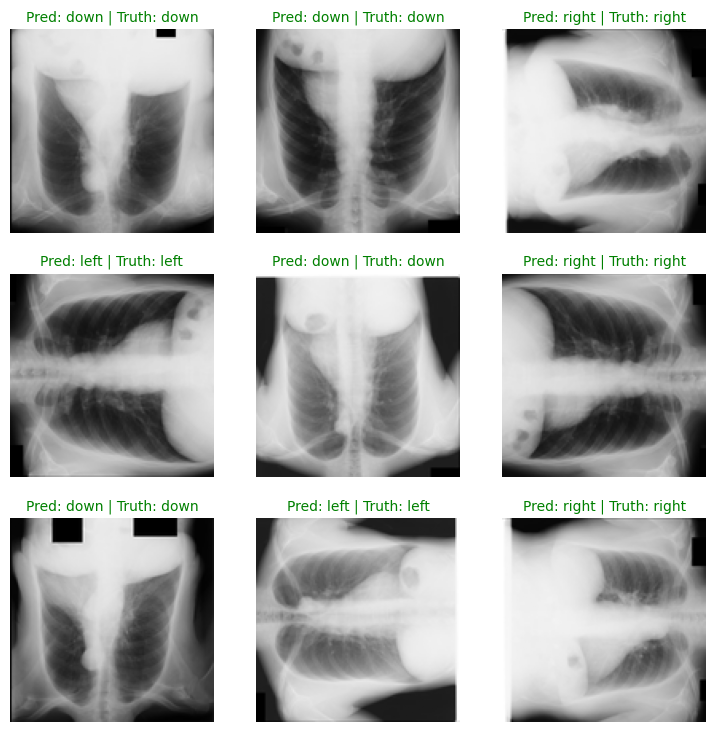

In [75]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[random_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);